# The collapse of polar seas

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [79]:
exp_list = ['focioifs-merge14']

# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_sfc.nc' % (exp,)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords').rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

In [80]:
# OpenIFS plev
ds_pl_all = []
for exp in exp_list:
    pl = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_pl.nc' % (exp,)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords').rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

In [81]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp in exp_list:
    moc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/derived/nemo/*1m*MOC.nc' % (exp,)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_moc_all.append(ds_moc)
    
    psi = '/data/user/jkjellsson/esm-experiments/focioifs/%s/derived/nemo/*1m*PSI.nc' % (exp,)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_psi_all.append(ds_psi)

In [82]:
ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Compare 1910-1920 and 1920-1930

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


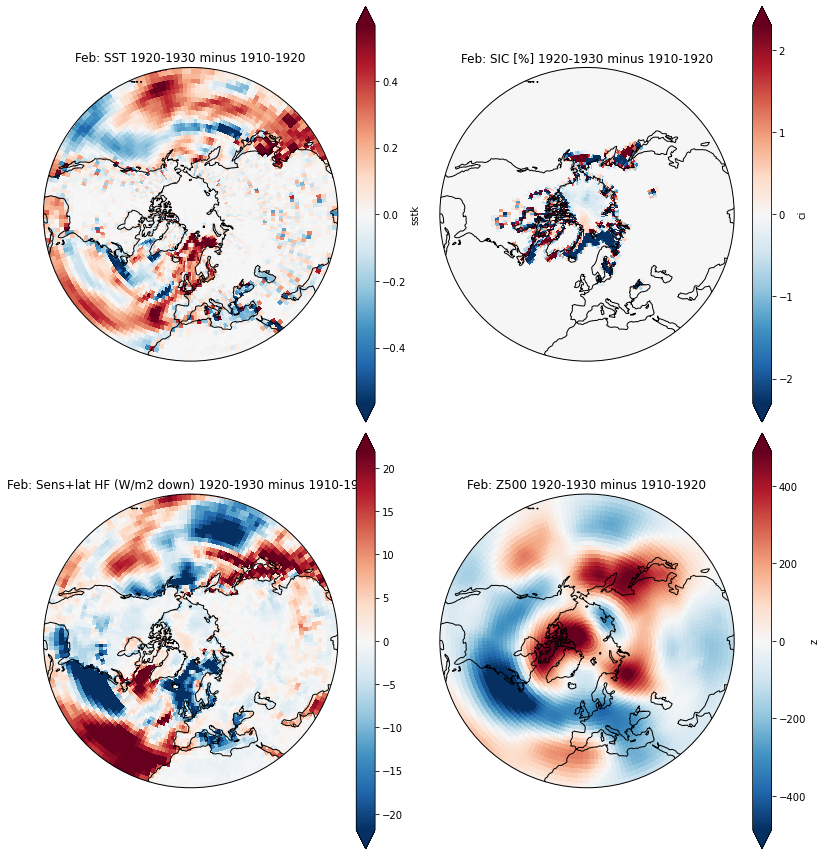

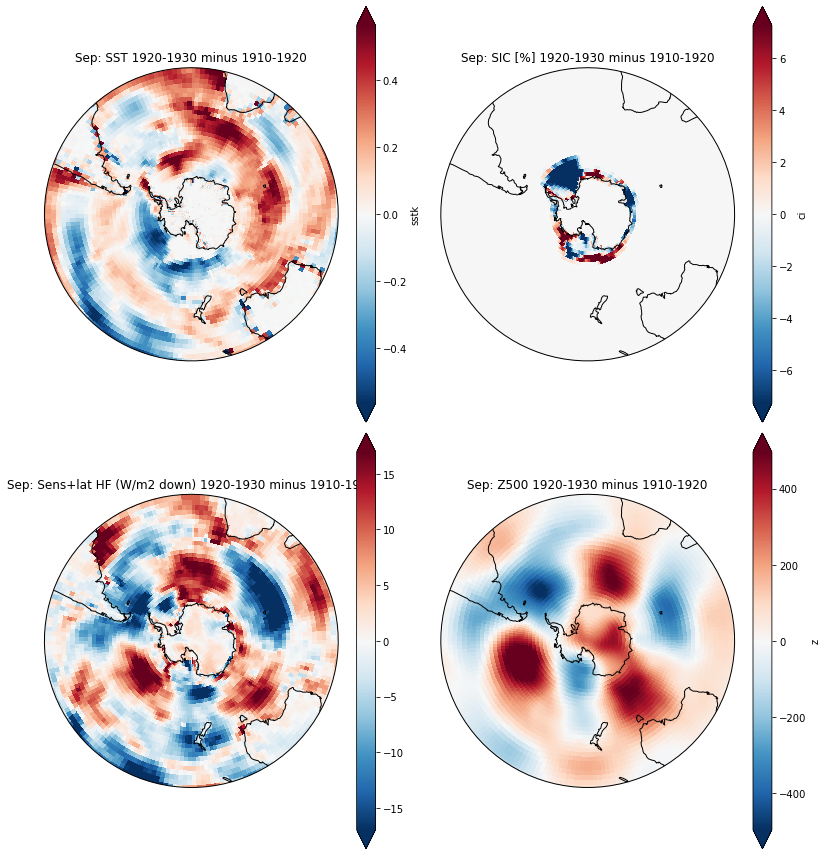

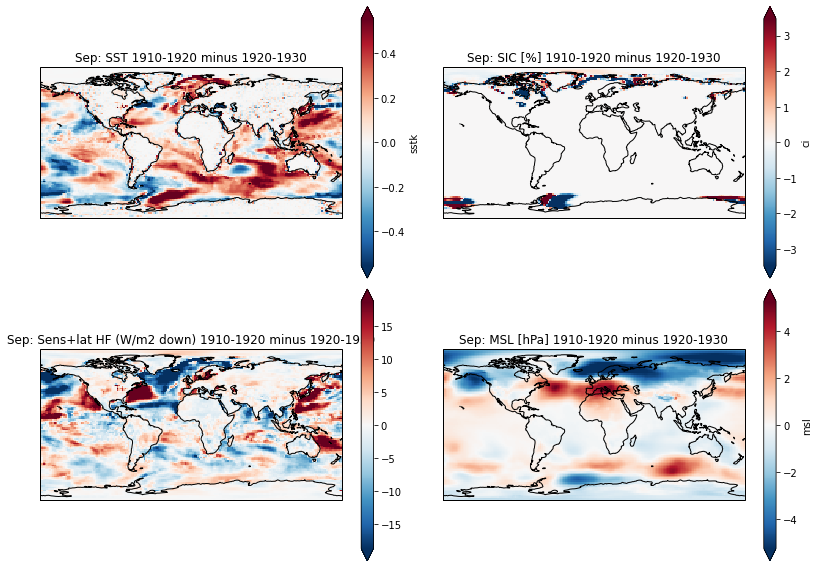

In [83]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

time2 = slice('1910-01-01','1920-01-01')
time1 = slice('1920-01-01','1930-01-01')

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl  = ds_pl_all[i]
    exp = exp_list[i]
    
    t2m = ds_sfc['2t'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['2t'].sel(time=time2).groupby('time.month').mean('time')
    msl = ds_sfc['msl'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['msl'].sel(time=time2).groupby('time.month').mean('time')
    
    z500 = ds_pl['z'].sel(pressure_levels=50000).sel(time=time1).groupby('time.month').mean('time') - ds_pl['z'].sel(pressure_levels=50000).sel(time=time2).groupby('time.month').mean('time')
    
    sst = ds_sfc['sstk'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['sstk'].sel(time=time2).groupby('time.month').mean('time')
    ci  = ds_sfc['ci'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['ci'].sel(time=time2).groupby('time.month').mean('time')
    
    sshf = ds_sfc['sshf'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['sshf'].sel(time=time2).groupby('time.month').mean('time')
    slhf = ds_sfc['slhf'].sel(time=time1).groupby('time.month').mean('time') - ds_sfc['slhf'].sel(time=time2).groupby('time.month').mean('time')
    
    feb = 2 # Feb
    sep = 9 # Sep
    
    prj = ccrs.NorthPolarStereo()
    map_ext = [-180, 180, 20, 90]
    
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(221,projection=prj)
    ax1.set_extent(map_ext, ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.coastlines()
    sst.sel(month=feb).plot(ax=ax1,robust=True,transform=ccrs.PlateCarree())
    ax1.set_title('Feb: SST 1920-1930 minus 1910-1920')
    
    ax2  = fig1.add_subplot(222,projection=prj)
    ax2.set_extent(map_ext, ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    ax2.coastlines()
    (ci*1e2).sel(month=feb).plot(ax=ax2,robust=True,transform=ccrs.PlateCarree())
    ax2.set_title('Feb: SIC [%] 1920-1930 minus 1910-1920')
    
    ax3  = fig1.add_subplot(223,projection=prj)
    ax3.set_extent(map_ext, ccrs.PlateCarree())
    ax3.set_boundary(circle, transform=ax3.transAxes)
    ax3.coastlines()
    ((sshf+slhf)/86400).sel(month=feb).plot(ax=ax3,robust=True,transform=ccrs.PlateCarree())
    ax3.set_title('Feb: Sens+lat HF (W/m2 down) 1920-1930 minus 1910-1920')
    
    ax4  = fig1.add_subplot(224,projection=prj)
    ax4.set_extent(map_ext, ccrs.PlateCarree())
    ax4.set_boundary(circle, transform=ax4.transAxes)
    ax4.coastlines()
    z500.sel(month=feb).plot(ax=ax4,robust=True,transform=ccrs.PlateCarree())
    ax4.set_title('Feb: Z500 1920-1930 minus 1910-1920')
    
    fig1.tight_layout()
    fig1.savefig('collapse_northpole_feb')
    
    prj = ccrs.SouthPolarStereo()
    map_ext = [-180, 180, -90, -20]
    
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(221,projection=prj)
    ax1.set_extent(map_ext, ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.coastlines()
    sst.sel(month=sep).plot(ax=ax1,robust=True,transform=ccrs.PlateCarree())
    ax1.set_title('Sep: SST 1920-1930 minus 1910-1920')
    
    ax2  = fig1.add_subplot(222,projection=prj)
    ax2.set_extent(map_ext, ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    ax2.coastlines()
    (ci*1e2).sel(month=sep).plot(ax=ax2,robust=True,transform=ccrs.PlateCarree())
    ax2.set_title('Sep: SIC [%] 1920-1930 minus 1910-1920')
    
    ax3  = fig1.add_subplot(223,projection=prj)
    ax3.set_extent(map_ext, ccrs.PlateCarree())
    ax3.set_boundary(circle, transform=ax3.transAxes)
    ax3.coastlines()
    ((sshf+slhf)/86400).sel(month=sep).plot(ax=ax3,robust=True,transform=ccrs.PlateCarree())
    ax3.set_title('Sep: Sens+lat HF (W/m2 down) 1920-1930 minus 1910-1920')
    
    ax4  = fig1.add_subplot(224,projection=prj)
    ax4.set_extent(map_ext, ccrs.PlateCarree())
    ax4.set_boundary(circle, transform=ax4.transAxes)
    ax4.coastlines()
    z500.sel(month=sep).plot(ax=ax4,robust=True,transform=ccrs.PlateCarree())
    ax4.set_title('Sep: Z500 1920-1930 minus 1910-1920')
    
    fig1.tight_layout()
    fig1.savefig('collapse_southpole_sep')
    
    dec = 12
    prj = ccrs.PlateCarree()
    map_ext = [-180, 180, -90, 90]
    
    fig1 = plt.figure(figsize=(12,8))
    ax1  = fig1.add_subplot(221,projection=prj)
    ax1.coastlines()
    sst.sel(month=dec).plot(ax=ax1,robust=True,transform=ccrs.PlateCarree())
    ax1.set_title('Sep: SST 1910-1920 minus 1920-1930')
    
    ax2  = fig1.add_subplot(222,projection=prj)
    ax2.coastlines()
    (ci*1e2).sel(month=dec).plot(ax=ax2,robust=True,transform=ccrs.PlateCarree())
    ax2.set_title('Sep: SIC [%] 1910-1920 minus 1920-1930')
    
    ax3  = fig1.add_subplot(223,projection=prj)
    ax3.coastlines()
    ((sshf+slhf)/86400).sel(month=dec).plot(ax=ax3,robust=True,transform=ccrs.PlateCarree())
    ax3.set_title('Sep: Sens+lat HF (W/m2 down) 1910-1920 minus 1920-1930')
    
    ax4  = fig1.add_subplot(224,projection=prj)
    ax4.coastlines()
    (msl*1e-2).sel(month=dec).plot(ax=ax4,robust=True,transform=ccrs.PlateCarree())
    ax4.set_title('Sep: MSL [hPa] 1910-1920 minus 1920-1930')
    
    fig1.tight_layout()
    
   

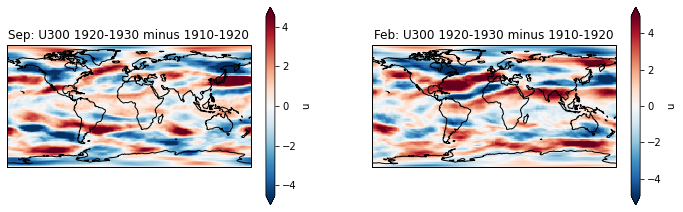

In [84]:
for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl  = ds_pl_all[i]
    ds_psi = ds_psi_all[i]
    exp = exp_list[i]
    
    u_natl1 = ds_pl['u'].sel(time=time1).groupby('time.month').mean('time')
    u_natl2 = ds_pl['u'].sel(time=time2).groupby('time.month').mean('time')
    u_natl_zm1 = u_natl1.sel(lon=slice(280,360),lat=slice(20,80)).mean('lon') 
    u_natl_zm2 = u_natl2.sel(lon=slice(280,360),lat=slice(20,80)).mean('lon')
    u300 = (u_natl1 - u_natl2).sel(pressure_levels=30000)
    u_natl_zm = u_natl_zm1 - u_natl_zm2
    
    
    
    prj = ccrs.PlateCarree()
    
    fig1 = plt.figure(figsize=(12,8))
    
    ax1  = fig1.add_subplot(221,projection=prj)
    ax1.coastlines()
    u300.sel(month=sep).plot(ax=ax1,robust=True,transform=ccrs.PlateCarree())
    ax1.set_title('Sep: U300 1920-1930 minus 1910-1920')
    
    ax2  = fig1.add_subplot(222,projection=prj)
    ax2.coastlines()
    u300.sel(month=feb).plot(ax=ax2,robust=True,transform=ccrs.PlateCarree())
    ax2.set_title('Feb: U300 1920-1930 minus 1910-1920')
    

<xarray.DataArray 'sobarstf' (time: 2858)>
array([148.37778, 169.95837, 173.2912 , ..., 128.27592, 115.40252,
       119.30654], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2089-12-16 12:00:00


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


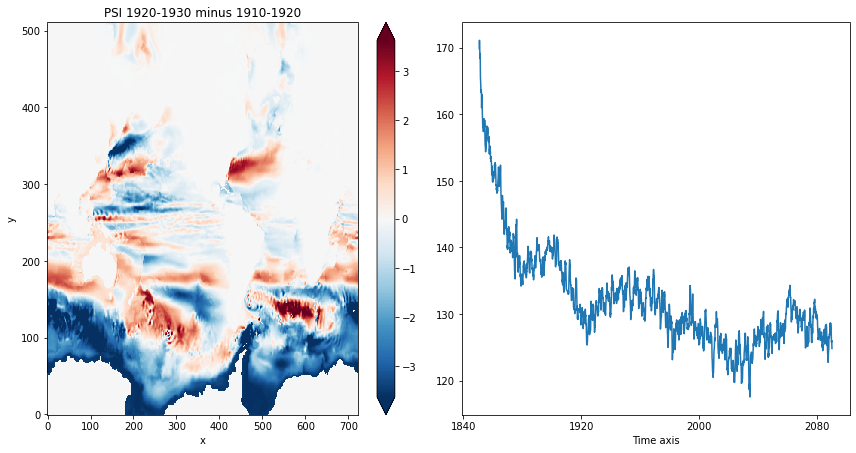

In [90]:
for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl  = ds_pl_all[i]
    ds_psi = ds_psi_all[i]
    exp = exp_list[i]
    
    bpsi1 = ds_psi['sobarstf'].sel(time=time1).mean('time')
    bpsi2 = ds_psi['sobarstf'].sel(time=time2).mean('time')
    bpsi  = (bpsi1 - bpsi2) * 1e-6
    
    drakes = ds_psi['sobarstf'].sel(x=450,y=80)
    draken = ds_psi['sobarstf'].sel(x=450,y=130)
    drake  = (drakes - draken).compute() * 1e-6
    print(drake)
    drake_12 = drake.rolling(time=12).mean()
    
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(221)
    (bpsi * da_orca05_mask).plot(ax=ax1,robust=True)
    ax1.set_title('PSI 1920-1930 minus 1910-1920')
    
    ax2  = fig1.add_subplot(222)
    drake_12.plot(ax=ax2)
    ax2.set_title('Drake Passage transport [Sv]')
    
    #ax1.set_xlim([400,500])
    #ax1.set_ylim([80,200])
    
    #ax1.plot(,'-k')
    
    fig1.tight_layout()
    